# Proje 2 - Scikit-learn ile Makine Öğrenmesi (Tahminleme)

* Aşağıdaki sorularda belirtilen tahmin problemlerinin çözümlerini, istenilenleri yerine getirerek ilgili boş hücrelere yazınız ve adı öğrenci numaranızdan oluşan nihai Jupyter Notebook (.ipynb) dosyasını, 17.06.2020 Çarşamba gece yarısına kadar EgeDers web sitesinde ilgili ders sayfasını kullanarak sisteme yükleyiniz. Bu durumda projeniz 120 puan üzerinden değerlendirilecek ve final sınavı notu yerine geçecektir. Proje teslimi 24.06.2020 Çarşamba gece yarısına kadar devam edecektir. Bu durumda projeniz 100 puan üzerinden değerlendirilecek ve bütünleme sınavı notu yerine geçecektir. Gönderilen tüm 2. projelerin notları, 26.06.2020 Cuma günü ilan edilecektir.
* Herhangi bir sorunuz olursa, EgeDers web sitesindeki ilgili ders sayfasında bu proje ile ilgili açılan forumu kullanınız.

**Açıklamalar:**
* Proje-1'de verilen Stackoverflow'un 2019 yılı için geliştiricilerle yaptığı anket sonuçlarını içeren "survey_results_public.csv" adlı dosya kullanılacaktır.
* Sorularda verilen her tahmin problemi için aşağıdaki işlemler adım adım gerçekleştirilecektir:
  1. Her tahmin modeli için kullanılması gereken öznitelikleri (çıktı değişkeni üzerinde etkisi olduğunu düşündüğünüz öznitelikleri) belirleyiniz.
  2. Kategorik olan sütunları one-hot encoding yöntemi ile dönüştürünüz. Örneğin:
  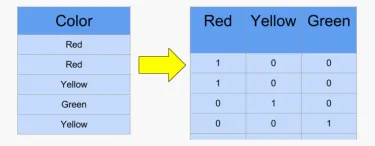
  3. Kategorik olmayan sütunlarda boş veri varsa uygun doldurma yöntemi (imputation) ile doldurunuz ya da ilgili satırları ihmal ediniz.
  4. Problem bir **regresyon problemi** ise k-fold cross-validation ile probleme uygun metrikler kullanarak tahmin modelinizin performansını değerlendiriniz ve hangi özniteliklerin çıktı değişkenini daha fazla etkilediğini yorumlayınız. Problem bir **sınıflandırma problemi** ise modelde kullanılacak hyper-parametre aramasını k-fold cross-validation ile yaparak (GridSearchCV modülünü kullanabilirsiniz), test verisi üzerinde probleme uygun metrikler kullanarak tahmin modelinizin performansını değerlendiriniz.
  5. Veri setinde olmayan yeni bir veri için geliştirdiğiniz model üzerinden bir tahminleme yapınız.
* İşlemleri gerçekleştirirken gerekli gördüğünüz yerleri (tercih ettiğiniz birşeyin nedeni v.b. gibi) açıklayınız.

In [1]:
#import edilen bütün modüller bu blokta bulunmaktadır.
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Verisetini soruya göre işleme almadan önce bu blokta genel olarak preprocessing işlemi yapılmaktadır.
survey_19= pd.read_csv("survey_results_public.csv")


#okunabilirlik açısından kolay olsun diye 1.projedeki gibi MainBranch kolonunu değiştirdim.
survey_19['MainBranch'].replace({'I am a student who is learning to code': 'Student',
  'I am not primarily a developer, but I write code sometimes as part of my work': 'Not a Developer',
  'I am a developer by profession':  'Developer',
  'I code primarily as a hobby':   'Code as hobby',
  'I used to be a developer by profession, but no longer am': 'Was a Developer'}, inplace=True)


#respondent sütununu index olarak ayarladım.
survey_19.set_index('Respondent', inplace = True)


#Haftalık çalışma saati (WorkWeekHrs) ya da yıllık maaş (ConvertedComp) sütunlarındaki değerleri, 
#ilgili sütunun ortalamasının %99'undan daha uzakta veri içeren satırları sildim.
#Burada bulunan ayrık veriler model başarısını olumsuz etkileyebilirdi.
survey_19.drop(survey_19[(survey_19['WorkWeekHrs'] > survey_19['WorkWeekHrs'].mean()*1.99)
                         |(survey_19['WorkWeekHrs'] < survey_19['WorkWeekHrs'].mean()*0.01)].index, inplace = True)

survey_19.drop(survey_19[(survey_19['ConvertedComp'] > survey_19['ConvertedComp'].mean()*1.99)|
                         (survey_19['ConvertedComp'] < survey_19['ConvertedComp'].mean()*0.01)].index, inplace = True)


#CompTotal sütununu kullanabilmek için her katılımcı için aynı ölçekte olması gerekiyordu. Bu yüzden güncelleme yaptım.
survey_19['CompTotal'].loc[survey_19['CompFreq'] == 'Monthly'] *= 12
survey_19['CompTotal'].loc[survey_19['CompFreq']=='Weekly'] *= 50

#YearsCode ve YearsCodePro sütunları normalde int değer içeriyor ama arada 2 tane string olduğu için tipi object olarak 
#görünüyor. Bunu düzeltmeden önce tipi bozan sütunları replace ederek düzeltme yaptım.
survey_19.YearsCode.replace({'Less than 1 year': 0, 'More than 50 years':50}, inplace=True)
survey_19.YearsCodePro.replace({'Less than 1 year': 0, 'More than 50 years':50}, inplace=True)


C:\Users\Numan\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Soru 1: Bir geliştiricinin açık kaynak yazılımlara katkıda bulunup bulunmadığının (```OpenSourcer```) tahminlenmesi
* "```Never```" ve "```Less than once per year```" yanıtları "```Katkıda bulunuyor```", "```Less than once a month but more than once per year```" ve "```Once a month or more often```" yanıtları  "```Katkıda bulunmuyor```" şeklinde ele alınmalıdır.

In [3]:
# Bu soruda kullanmak için seçtiğim öznitelikler
usecols=['MainBranch','Hobbyist','WorkWeekHrs','YearsCodePro','YearsCode','CodeRevHrs','EdLevel','OpenSourcer']

# Katkıda bulunuyor = 1, Katkıda bulunmuyor = 0 olarak güncellenmesi
survey_19.OpenSourcer.replace(to_replace=["Less than once per year","Never"], value = 0,inplace=True)
survey_19.OpenSourcer.replace(to_replace=["Less than once a month but more than once per year","Once a month or more often"],
                              value = 1,inplace=True)


#kategorik verinin yerine 1 ve 0 verilmesi
survey_19.Hobbyist.replace({'Yes':1, 'No':0}, inplace=True)

#1. soru için kullancağım dataset
df1 = survey_19[usecols]

#OneHotEncoding yapılması gereken kolonlar ve df1 e eklenmesi
dummy_list = ['MainBranch','EdLevel']
dummy_df = pd.get_dummies(survey_19[dummy_list])
df1 = pd.concat([df1,dummy_df], axis=1)
df1.drop(dummy_list, inplace=True, axis=1)





In [4]:
#Eğer NaN Valueları silmeyip her kolonun ortalaması ile doldurursam bu kodları çalıştırmam gerekiyor.
#Bu kodlar ile modeli eğitirsem model başarısını en iyi olarak 0.64 buluyorum. AŞağıda örnek olarak bu kodların çalıştığı halini
#göreceksiniz. Boşlukların silinmesiyle elde edilen başarı oranını bir alt blokta yorum olarak ekledim.
df1.WorkWeekHrs.fillna(df1.WorkWeekHrs.mean(), inplace=True)
df1.YearsCode.fillna(df1.WorkWeekHrs.mean(), inplace=True)
df1.YearsCodePro.fillna(df1.WorkWeekHrs.mean(), inplace=True)
df1.CodeRevHrs.fillna(df1.WorkWeekHrs.mean(), inplace=True)

In [5]:
#Eğer NaN valueları silip işlemleri yaparsak model başarısını en iyi olarak 0.62 buluyorum. 
#df1_2 = df1.dropna()
#Burada önceden çalıştırdığım ve başarısını ölçtüğüm NaN valueler silinmişken yapılan ölçüm sonuçlar var
# Accuracy score of Logistic Regression is 0.6193677541282768
# Best parameters of Logistic Regression is  {'penalty': 'l2', 'solver': 'lbfgs'}
# Accuracy score of Decision Tree is 0.5729880348602275
# Best parameters of Decision Tree is  {'criterion': 'gini', 'splitter': 'best'}
# Accuracy score of KNeighbors Classifier is 0.5776930052307532
# Best parameters of KNeighbors Classifier is  {'n_neighbors': 7, 'weights': 'uniform'}

In [6]:
#Verisetinin bağımlı ve bağımsız değişkene ayrılması
X = df1.loc[:,df1.columns != 'OpenSourcer']
y = df1.OpenSourcer

#Veri setinin train ve test olarak ayrılması
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [7]:
#Bu blokta modellere ait en iyi parametreleri ve bu parametreler kullanılarak elde edilen en iyi başarı oranını buluyorum.

lr = LogisticRegression(max_iter=10000)
params = {'penalty': ['none', 'l2'], 'solver':['newton-cg', 'lbfgs','sag', 'saga']}
g_search = GridSearchCV(estimator=lr,param_grid=params, cv=10)
g_search.fit(X,y)
print("Accuracy score of Logistic Regression is "+str(g_search.best_score_))
print("Best parameters of Logistic Regression is ", g_search.best_params_)


#Yaptığım denemelerde en iyi oranı Logistic Regression ile buluyorum. o yüzden Bu modelleri yorum satırı haline getirdim.
#Bu blok çalışırken gereksiz zaman harcanmasındna kaçındım.
#Yukarıda örnek olarak bu modellerden elde edilen best_param ve best_score bulunmaktadır.


# DTclf = DecisionTreeClassifier()
# params = {'criterion':['gini', 'entropy'], 'splitter':['best','random']}
# g_search = GridSearchCV(estimator=DTclf,param_grid=params, cv=10)
# g_search.fit(X,y)
# print("Accuracy score of Decision Tree is "+str(g_search.best_score_))
# print("Best parameters of Decision Tree is ", g_search.best_params_)

# knn = KNeighborsClassifier()
# params = {'n_neighbors' : [3,5,7], 'weights': ['distance','uniform']}
# g_search = GridSearchCV(estimator=knn,param_grid=params, cv=10)
# g_search.fit(X,y)
# print("Accuracy score of KNeighbors Classifier is "+str(g_search.best_score_))
# print("Best parameters of KNeighbors Classifier is ", g_search.best_params_)

Accuracy score of Logistic Regression is 0.6468618479878089
Best parameters of Logistic Regression is  {'penalty': 'none', 'solver': 'lbfgs'}


In [8]:
#Hangi kolonların model için daha anlamlı olduğunu bulmak için RFE sınıfını kullanıyorum.
#En anlamlı 5 kolonu seçeceğiz. Burda model olarak Logistic Regresyon kullandım. Çünkü en yüksek accuracy scoru bu modelden
#elde ettim. Çıktıda True olarak verilen sütunlar en anlamlı 5 kolon olarak söyleyebiliriz.

rfe = RFE(lr, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

rfe_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_, rfe.ranking_)),columns=['Column','isFirst5','Rank'])
rfe_df[rfe_df.isFirst5]

,Column,isFirst5,Rank
0,Hobbyist,True,1
7,MainBranch_Not a Developer,True,1
8,MainBranch_Student,True,1
9,MainBranch_Was a Developer,True,1
14,"EdLevel_Other doctoral degree (Ph.D, Ed.D., etc.)",True,1


In [9]:
#Bu blokta verisetinde olmayan bir verinin OpenSourcer durumunun tahmin edilmesi yapılmaktadır.
new_data = np.array([1, 70, 10,15,30,0,1,0,0,0,0,1,0,0,0,0,0,0,0])
lr.fit(X,y)
if(lr.predict(new_data.reshape(1,-1)) == 0):
    print("Tahmin edilen: "+ "Katkıda bulunmuyor.")
else:
    print("Tahmin edilen: "+ "Katkıda bulunuyor.")

Tahmin edilen: Katkıda bulunmuyor.


### Soru 2: Bir geliştiricinin genel olarak, şu ana kadarki kariyerinden memnuniyet derecesinin (```CareerSat```) tahminlenmesi

In [10]:
#bu soru için kullanacağım kolonlar şunlardır:
usecols = ['ConvertedComp','Employment','JobSat','EdLevel','CareerSat']

#memnuniyet derecelerini label encoding mantığıyla encode ediyorum.
CareerSat = { "Very dissatisfied" : 0, "Slightly dissatisfied" : 1,"Neither satisfied nor dissatisfied" : 2,
             "Slightly satisfied" : 3,"Very satisfied" : 4}

df2 = survey_19[usecols]
df2.CareerSat.replace(CareerSat, inplace=True)


dummy_list = ['Employment', 'EdLevel', 'JobSat']
dummy_df1 = pd.get_dummies(df2['Employment'])
dummy_df2 = pd.get_dummies(df2['EdLevel'])
dummy_df3 = pd.get_dummies(df2['JobSat'])
df2 = pd.concat([df2,dummy_df1,dummy_df2,dummy_df3], axis=1)
df2.drop(columns=dummy_list, inplace=True)
df2.dropna(inplace=True)

C:\Users\Numan\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
X = df2.loc[:, df2.columns!='CareerSat']
y = df2.CareerSat

DTclf = DecisionTreeClassifier()
params = {'criterion':['gini', 'entropy'], 'splitter':['best','random'],'max_depth':[6,7,8],'min_samples_leaf':[4,5,6]}
g_search = GridSearchCV(estimator=DTclf,param_grid=params, cv=10)
g_search.fit(X,y)
print("Accuracy score of Decision Tree is "+str(g_search.best_score_))
print("Best parameters of Decision Tree is ", g_search.best_params_)


#Denemelerimde gördüğüme göre bu veriler için RandomForest ve Knn eğitilmesi çok uzun sürüyor ve başarı oranı
#Decision Treeden çok düşük çıkıyor. O yüzden burada sadece Decision Treenin eğitimini yapacağım.
# RFclf = RandomForestClassifier()
# params = {'n_estimators':[100,150,200], 'criterion':['gini','entropy'], 'random_state':[10,20]}
# g_search = GridSearchCV(estimator=RFclf,param_grid=params, cv=10)
# g_search.fit(X,y)
# print("Accuracy score of Random Forest Classifier is "+str(g_search.best_score_))
# print("Best parameters of Random Forest Classifier is ", g_search.best_params_)

# knn = KNeighborsClassifier()
# params = {'n_neighbors' : [3,5,7], 'weights': ['distance','uniform']}
# g_search = GridSearchCV(estimator=knn,param_grid=params, cv=10)
# g_search.fit(X,y)
# print("Accuracy score of KNeighbors Classifier is "+str(g_search.best_score_))
# print("Best parameters of KNeighbors Classifier is ", g_search.best_params_)

Accuracy score of Decision Tree is 0.574136910633261
Best parameters of Decision Tree is  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'splitter': 'best'}


In [12]:
#Decision Tree için Best parametreyi bulduktan sonra bir sonraki blokta model için en anlamlı 5 sütunu göreceğiz.
DTclf = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5)

In [13]:
#Hangi kolonların model için daha anlamlı olduğunu bulmak için RFE sınıfını kullanıyorum.
#En anlamlı 5 kolonu seçeceğiz. Burda model olarak Logistic Regresyon kullandım. Çünkü en yüksek accuracy scoru bu modelden
#elde ettim. Çıktıda True olarak verilen sütunlar en anlamlı 5 kolon olarak söyleyebiliriz.
from sklearn.feature_selection import RFE
rfe = RFE(DTclf, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

rfe_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_, rfe.ranking_)),columns=['Column','isFirst5','Rank'])
rfe_df[rfe_df.isFirst5]

,Column,isFirst5,Rank
0,Hobbyist,True,1
1,WorkWeekHrs,True,1
2,YearsCodePro,True,1
3,YearsCode,True,1
4,CodeRevHrs,True,1


In [14]:
new_data = np.array([70000,1,0,0,0,0,0, 0,0,0,0,1,0,0,0,0,0,0,0,0,1])
DTclf.fit(X,y)
if(DTclf.predict(new_data.reshape(1,-1)) == 0):
    print("Tahmin edilen: "+ "Very Dissatisfied.")
elif(DTclf.predict(new_data.reshape(1,-1)) == 1):
    print("Tahmin edilen: "+ "Slightly dissatisfied.")
elif(DTclf.predict(new_data.reshape(1,-1)) == 2):
    print("Tahmin edilen: "+ "Neither satisfied nor dissatisfied")
elif(DTclf.predict(new_data.reshape(1,-1)) == 3):
    print("Tahmin edilen: "+ "Slightly Satisfied.")
else:
    print("Tahmin edilen: "+"Very Satisfied")

Tahmin edilen: Very Satisfied


### Soru 3: Bir geliştiricinin USD cinsinden mevcut yıllık toplam gelirinin (```ConvertedComp```) tahminlenmesi

In [15]:
# Bu soru için kullanılacak kolonlar
usecols = ['ConvertedComp', 'Country','CompTotal','YearsCodePro','DevType']

df3 = pd.DataFrame(survey_19[usecols])
df3.dropna(inplace=True)

In [16]:
#Burda tipi object olan sütunları encode etmek için tiplerini öğreniyoruz.
df3.dtypes

ConvertedComp    float64
Country           object
CompTotal        float64
YearsCodePro      object
DevType           object
dtype: object

In [17]:
#Verisetini eğitime hazır hale getiriyoruz.
devtypes = df3.DevType.str.get_dummies(sep=';')
country = pd.get_dummies(df3.Country)
df3.YearsCodePro = df3.YearsCodePro.astype(int)
df3 = pd.concat((df3,devtypes,country),axis=1)
df3.drop(columns = ['DevType','Country'],inplace=True)

In [18]:
#DataFrame i bağımlı ve bağımsız değişken olarak ayıralım
X = df3. loc[:,df3.columns != 'ConvertedComp']
y = df3.ConvertedComp
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)


In [19]:
#Regresyon testlerini yapmaya başlayabiliriz. Sırasıyla çeşitli modeller ve sütun kombinasyonları
#deneyerek en iyi r-square değerine ulaşmaya çalışacağım. r-square değeri 1 e ne kadar yakınsa modelin 
#başarısı o kadar iyi yorumunu yapabiliriz.
#Modelleri cross_validation modülü altında eğiteceğim.. 10 katlı çapraz doğrulama kullanacağım.
lin_reg = LinearRegression()
lin_reg_score = cross_val_score(lin_reg,X,y,scoring='r2', cv=10)
print("Lineer Regresyon için r-square değerleri: ", lin_reg_score)

dt_reg = DecisionTreeRegressor()
df_reg_score = cross_val_score(dt_reg,X,y,scoring='r2',cv=10)
print("Decision Tree Regresyon için r-square değerleri: ", lin_reg_score)

rf_reg = RandomForestRegressor()
rf_reg_score = cross_val_score(rf_reg,X,y,scoring='r2',cv=10)
print("Random Forest Regresyon için r-square değerleri: ",rf_reg_score)

Lineer Regresyon için r-square değerleri:  [0.59944756 0.57847969 0.5796614  0.56957047 0.58243206 0.57824001
 0.59612982 0.60537226 0.56532766 0.59115054]
Decision Tree Regresyon için r-square değerleri:  [0.59944756 0.57847969 0.5796614  0.56957047 0.58243206 0.57824001
 0.59612982 0.60537226 0.56532766 0.59115054]
Random Forest Regresyon için r-square değerleri:  [0.97487165 0.96982977 0.95777962 0.95841842 0.95905795 0.97300242
 0.9582841  0.97216498 0.95208803 0.96683545]


In [20]:
#RandomForest Regression modeli için r-square, Mean Square Error, Mean Absolute Error değerlerine bakalım.
rf_reg.fit(X_train,y_train)
y_pred = rf_reg.predict(X_test)
mse_score = mean_squared_error(y_test, y_pred)
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE score:", mse_score)
print("MAE score:", mae_score)
print("R2 score:", r2)



MSE score: 94668854.09168668
MAE score: 1981.4708988131981
R2 score: 0.9599661033929985


In [21]:
#Şimdi çeşitli k değerleri için KBest ve chi-square kullanrak en iyi k adet feature seçeceğim.

In [22]:
#Bu işlemi  k=[20,50,100,120,150] değerleri için yaptığımızda DevType sütunları yerine Country sütunlarının
#ne kadar fazla olduğunu görüyoruz. Bu soru için Country sütununu en önemli sütun olarak söyleyebiliriz.
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=20)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print("20 feature: ",chi_feature)
chi_selector = SelectKBest(chi2, k=50)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print("50 feature: ",chi_feature)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print("100 feature: ",chi_feature)
chi_selector = SelectKBest(chi2, k=120)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print("120 feature: ",chi_feature)
chi_selector = SelectKBest(chi2, k=150)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print("150 feature: ",chi_feature)

20 feature:  ['Australia', 'Canada', 'Denmark', 'Djibouti', 'Iceland', 'Israel', 'Japan', 'Jordan', "Lao People's Democratic Republic", 'New Zealand', 'Norway', 'Qatar', 'Saint Vincent and the Grenadines', 'Seychelles', 'Singapore', 'South Africa', 'Sweden', 'Switzerland', 'Timor-Leste', 'United Kingdom']
50 feature:  ['Argentina', 'Australia', 'Bahrain', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Czech Republic', 'Denmark', 'Djibouti', 'Ethiopia', 'Georgia', 'Honduras', 'Hong Kong (S.A.R.)', 'Hungary', 'Iceland', 'India', 'Iran', 'Israel', 'Japan', 'Jordan', "Lao People's Democratic Republic", 'Malaysia', 'Mexico', 'New Zealand', 'Nigeria', 'Norway', 'Poland', 'Qatar', 'Romania', 'Russian Federation', 'Saint Vincent and the Grenadines', 'Saudi Arabia', 'Seychelles', 'Singapore', 'South Africa', 'South Korea', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Timor-Leste', 'Trinidad and Tobago', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United S

In [23]:
#en iyi 100 feature kullanarak tekrar model oluşturup r-square değerine bakalım.
# usecols= ['ConvertedComp','Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 
#           'Belarus', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 
#           'Colombia', 'Croatia', 'Czech Republic', "Côte d'Ivoire", 'Denmark', 'Djibouti', 'Dominican Republic', 'Egypt', 
#           'Ethiopia', 'Fiji', 'Georgia', 'Germany', 'Ghana', 'Guatemala', 'Guinea', 'Honduras', 'Hong Kong (S.A.R.)', 
#           'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Israel', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
#           'Kyrgyzstan', "Lao People's Democratic Republic", 'Libyan Arab Jamahiriya', 'Malaysia', 'Maldives', 'Mauritius', 
#           'Mexico', 'Mongolia', 'Morocco', 'Myanmar', 'Nepal', 'New Zealand', 'Nigeria', 'Norway', 'Oman', 'Pakistan',
#           'Paraguay', 'Peru', 'Philippines', 'Poland', 'Qatar', 'Republic of Korea', 'Republic of Moldova', 'Romania', 
#           'Russian Federation', 'Saint Vincent and the Grenadines', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 
#           'Singapore', 'Somalia', 'South Africa', 'South Korea', 'Sri Lanka', 'Sweden', 'Switzerland', 'Syrian Arab Republic',
#           'Taiwan', 'Tajikistan', 'Thailand', 'The former Yugoslav Republic of Macedonia', 'Timor-Leste', 'Trinidad and Tobago',
#           'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United Republic of Tanzania',
#           'United States', 'Uruguay', 'Viet Nam']
# df3 = df3[usecols]


In [24]:
#DataFrame i bağımlı ve bağımsız değişken olarak ayıralım
# X = df3. loc[:,df3.columns != 'ConvertedComp']
# y = df3.ConvertedComp

# lin_reg = LinearRegression()
# lin_reg_score = cross_val_score(lin_reg,X,y,scoring='r2', cv=10)
# print("Lineer Regresyon için r-square değerleri: ", lin_reg_score)

# dt_reg = DecisionTreeRegressor()
# df_reg_score = cross_val_score(dt_reg,X,y,scoring='r2',cv=10)
# print("Decision Tree Regresyon için r-square değerleri: ", lin_reg_score)

# rf_reg = RandomForestRegressor()
# rf_reg_score = cross_val_score(rf_reg,X,y,scoring='r2',cv=10)
# print("Random Forest Regresyon için r-square değerleri: ",rf_reg_score)

In [25]:
#Örneklerde görüldüğü gibi çeşitli feature sayılarıyla (20,50,100,150) daha iyi bir oran elde edemedik. 
#O yüzden ilk başta r-square=0.96 bulduğumuz RandomForest modeli ile verisetinde olmayan bir verinin ConvertedComp değerini 
#tahmin edeceğiz.


In [26]:
test_data = np.array([100000,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                      0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                      0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                      0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(1,-1)
result = rf_reg.predict(test_data)
print("Tahmin edilen ConvertedComp: ",result)

Tahmin edilen ConvertedComp:  [20017.15]


### Soru 4: Türkiye'deki bir geliştiricinin mevcut yıllık toplam gelirinin (```ConvertedComp```)  18000 USD değerinden yüksek mi düşük mü olduğunun tahminlenmesi
* 18000 ve üstü "```Yüksek```", 18000 altı "```Düşük```" şeklinde ele alınmalıdır.

In [27]:
#18000den küçük olan ConvertedComp için 0, büyük olan için 1 değerini verdikten sonra Ülkesi Türkiye olanlara ait veriyi df4
#isimli dataframe e atalım.

df4 = survey_19[survey_19.Country == 'Turkey']


usecols = ['ConvertedComp','WorkWeekHrs', 'YearsCode','EdLevel']

df4 = df4[usecols]

#18000 den küçükse 0 sınıfına büyük/eşit ise 1 sınıfına atama yapılması
df4['ConvertedComp']=df4['ConvertedComp'].apply(lambda x: 0 if x < 18000 else 1)

df4.WorkWeekHrs.fillna(df4.WorkWeekHrs.mean(), inplace=True)


df4['YearsCode'].replace({'Less than 1 year': 1,'More than 50 years':50}, inplace=True)

df4.dropna(inplace=True)
df4.YearsCode = df4.YearsCode.astype(int)

dummy_df = pd.get_dummies(df4.EdLevel)
df4 = pd.concat((df4,dummy_df), axis=1)
df4.drop(['EdLevel'], axis=1,inplace=True)

In [28]:
X = df4.loc[:, df4.columns!='ConvertedComp']
y = df4.ConvertedComp

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#sırasıyla GridSearcCV kullanarak modelleri deneyelim:
lr = LogisticRegression()
params = {'max_iter': [10000],'penalty': ['none', 'l2'], 'solver':['newton-cg', 'lbfgs','sag', 'saga']}
g_search = GridSearchCV(estimator=lr,param_grid=params, cv=10)
g_search.fit(X,y)
print("Accuracy score of Logistic Regression is "+str(g_search.best_score_))
print("Best parameters of Logistic Regression is ", g_search.best_params_)

DTclf = DecisionTreeClassifier()
params = {'criterion':['gini', 'entropy'], 'splitter':['best','random']}
g_search = GridSearchCV(estimator=DTclf,param_grid=params, cv=10)
g_search.fit(X,y)
print("Accuracy score of Decision Tree is "+str(g_search.best_score_))
print("Best parameters of Decision Tree is ", g_search.best_params_)

knn = KNeighborsClassifier()
params = {'n_neighbors' : [3,5,7], 'weights': ['distance','uniform']}
g_search = GridSearchCV(estimator=knn,param_grid=params, cv=10)
g_search.fit(X,y)
print("Accuracy score of KNeighbors Classifier is "+str(g_search.best_score_))
print("Best parameters of KNeighbors Classifier is ", g_search.best_params_)

Accuracy score of Logistic Regression is 0.7311965811965813
Best parameters of Logistic Regression is  {'max_iter': 10000, 'penalty': 'none', 'solver': 'saga'}
Accuracy score of Decision Tree is 0.7477045177045177
Best parameters of Decision Tree is  {'criterion': 'gini', 'splitter': 'best'}
Accuracy score of KNeighbors Classifier is 0.7820879120879121
Best parameters of KNeighbors Classifier is  {'n_neighbors': 7, 'weights': 'uniform'}


In [29]:
#Hangi kolonların model için daha anlamlı olduğunu bulmak için RFE sınıfını kullanıyorum.
#En anlamlı 5 kolonu seçeceğiz. Burda model olarak KNN kullanmak istedim fakat RFE KNNi desteklemiyor.
#Bu yüzden Decision Tree kullanacağım. Çünkü KNNden sonra en yüksek accuracy scoru bu modelden
#elde ettim.

rfe = RFE(DTclf, n_features_to_select=5)
rfe = rfe.fit(X, y)
rfe_df = pd.DataFrame(list(zip(X.columns,rfe.support_, rfe.ranking_)),columns=['Column','isFirst5','Rank'])
rfe_df[rfe_df.isFirst5]

,Column,isFirst5,Rank
0,WorkWeekHrs,True,1
1,YearsCode,True,1
3,"Bachelor’s degree (BA, BS, B.Eng., etc.)",True,1
5,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",True,1
8,"Secondary school (e.g. American high school, G...",True,1


In [30]:
new_data = np.array([35, 10, 0, 1, 0,0,0,0,0,0])
lr.fit(X,y)
if(lr.predict(new_data.reshape(1,-1)) == 0):
    print("Tahmin edilen: "+ "18000 USDden düşük.")
else:
    print("Tahmin edilen: "+ "18000 USDden yüksek.")

Tahmin edilen: 18000 USDden yüksek.


C:\Users\Numan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Soru 5: Bir geliştiricinin yıl olarak yaşının (```Age```) tahminlenmesi

In [31]:
usecols = ['Age', 'YearsCode','YearsCodePro','Country','SocialMedia','LanguageWorkedWith','DevType']
first_df = survey_19[usecols]
first_df.dropna(inplace=True)

first_df.YearsCode = first_df.YearsCode.astype(int)
first_df.YearsCodePro = first_df.YearsCodePro.astype(int)


dummy_df1 = pd.get_dummies(first_df.Country)
dummy_df2 = pd.get_dummies(first_df.SocialMedia)
dummy_df3 = first_df.LanguageWorkedWith.str.get_dummies(sep=';')
dummy_df4 = first_df.DevType.str.get_dummies(sep=';')

df5_1 = pd.concat((first_df,dummy_df1,dummy_df2,dummy_df3,dummy_df4), axis=1)
df5_1.drop(columns=['Country','SocialMedia','LanguageWorkedWith','DevType'],inplace=True)

C:\Users\Numan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Numan\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [32]:
#DataFrame i bağımlı ve bağımsız değişken olarak ayıralım
X = df5_1. loc[:,df5_1.columns != 'Age']
y = df5_1.Age


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [33]:
#Regresyon testlerini yapmaya başlayabiliriz. Sırasıyla çeşitli modeller ve sütun kombinasyonları
#deneyerek en iyi r-square değerine ulaşmaya çalışacağım. r-square değeri 1 e ne kadar yakınsa modelin 
#başarısı o kadar iyi yorumunu yapabiliriz.
#Modelleri cross_validation modülü altında eğiteceğim.. 10 katlı çapraz doğrulama kullanacağım.
lin_reg = LinearRegression()
lin_reg_score = cross_val_score(lin_reg,X,y,scoring='r2', cv=10)
print("Lineer Regresyon için r-square değerleri: ", lin_reg_score)

dt_reg = DecisionTreeRegressor()
df_reg_score = cross_val_score(dt_reg,X,y,scoring='r2',cv=10)
print("Decision Tree Regresyon için r-square değerleri: ", lin_reg_score)

#Burası çok zaman almasına rağmen r-square yüksek bulamadı. o yüzden yorum satırı yaptım.
# rf_reg = RandomForestRegressor()
# rf_reg_score = cross_val_score(rf_reg,X,y,scoring='r2',cv=10)
# print("Random Forest Regresyon için r-square değerleri: ",rf_reg_score)
# Random Forest Regresyon için r-square değerleri:  [0.73846248 0.74780984 0.74842163 0.73523518 0.75851609 0.73782665
#  0.74611879 0.74103423 0.75492945 0.73241357]

Lineer Regresyon için r-square değerleri:  [0.73229025 0.74026256 0.73898121 0.71875781 0.74501281 0.72808207
 0.73742562 0.72481534 0.74481562 0.72214841]
Decision Tree Regresyon için r-square değerleri:  [0.73229025 0.74026256 0.73898121 0.71875781 0.74501281 0.72808207
 0.73742562 0.72481534 0.74481562 0.72214841]


In [34]:
#Bu soruda 3 tahminleyicinin hepsi yaklaşık olarak benzer sonuçlar veriyor.
#O yüzden eğitim süresi en az olan Lineer Regresyonu baz alarak tahminleme yapacağım.

lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse_score = mean_squared_error(y_test, y_pred)
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE score:", mse_score)
print("MAE score:", mae_score)
print("R2 score:", r2)

MSE score: 18.38180072306275
MAE score: 2.9804682869739176
R2 score: 0.7340237772814302


In [35]:
#şimdi farklı kolonlar kullanarak r-square değerimizi artırıp artıramayacağımıza bakacağız.
#ilk olarak sadece country ve social media kolonlarına bakalım
usecols = ['Age','Country','SocialMedia']
first_df = survey_19[usecols]
first_df.dropna(inplace=True)
dummy_df1 = pd.get_dummies(first_df.Country)
dummy_df2 = pd.get_dummies(first_df.SocialMedia)
df5_2= pd.concat((first_df,dummy_df1,dummy_df2), axis=1)
df5_2.drop(columns=['Country','SocialMedia'],inplace=True)
X = df5_2. loc[:,df5_2.columns != 'Age']
y = df5_2.Age
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse_score = mean_squared_error(y_test, y_pred)
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE score:", mse_score)
print("MAE score:", mae_score)
print("R2 score:", r2)

C:\Users\Numan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


MSE score: 6.21034031570819e+22
MAE score: 3414896133.8467345
R2 score: -7.47046167608364e+20


In [36]:
#Anlamlı bir sonuç elde edemedik. Bu sefer LanguageWorkedWith ve Country sütunları kullanıp deneyelim.
usecols = ['Age','Country','LanguageWorkedWith']
first_df = survey_19[usecols]
first_df.dropna(inplace=True)
dummy_df1 = pd.get_dummies(first_df.Country)
dummy_df2 = first_df.LanguageWorkedWith.str.get_dummies(sep=';')
df5_3 = pd.concat((first_df,dummy_df1,dummy_df2), axis=1)
df5_3.drop(columns=['Country','LanguageWorkedWith'],inplace=True)
X = df5_3. loc[:,df5_3.columns != 'Age']
y = df5_3.Age
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse_score = mean_squared_error(y_test, y_pred)
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE score:", mse_score)
print("MAE score:", mae_score)
print("R2 score:", r2)

C:\Users\Numan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


MSE score: 3.027223319514818e+22
MAE score: 2342664532.936115
R2 score: -3.6008334626084513e+20


In [37]:
#Görüldüğü gibi ilk başta elde ettiğimiz tutarlı sonuçları elde edemiyoruz. o yüzden df5_1 i kullanarak verisetinde olmayan bir
#veride Age tahminleme yapacağım.


In [38]:
X = df5_1. loc[:,df5_1.columns != 'Age']
y = df5_1.Age
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
lin_reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
test_data = np.array([10,8,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0 ,0,0,0,0,0,0,0,0,0,0 ,0,0,0,0,0,0,0,0,0,0 ,0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,1,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,1, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,1,1,0,0,0, 0,0,0,1,1,0,0,0,0,0,
                     0,0,0,0,1,0,0,0,1,0, 0,0,0,0,0,0,0,0,0,1, 0,0,0,0,0,0,0,0,0,0, 0,0,0,0,1]).reshape(1,-1)
result = lin_reg.predict(test_data)
print("Tahmin edilen yaş: ",result)

Tahmin edilen yaş:  [30.49903815]
